# PageRank

> *Numerical Optimization and Large Scale Linear Algebra*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

In the file **Stanweb.dat**, you will find in compressed form the connectivity matrix for the webpages of Stanford University. Specifically, in the first column are contained the nodes, while in the second the node with which is connected. Using the notation of the paper **<a href="https://github.com/sapaladas/msc_data_science/blob/main/q3-numerical_optimization_and_large_scale_linear_algebra/pagerank/readings/pagerank.pdf">Deeper Inside PageRank</a>** do the following:

*Question 1*<br>Find the vector $\pi$ with ***i) the Power method*** and ***ii) the Gauss-Seidel method*** as they described in paragraph 5.1 and 5.2 of the tutorial. For both methods consider as $\alpha = 0.85$, stopping criterion $\tau = 10^{-8}$ and the vector $\alpha$ having $1$ if it corresponds to a node with no out links and $0$ otherwise. Are the results the same for both methods? Which method seems to be faster?

*Question 2*<br>Do the previous task with $\alpha=0.99$. Your remarks on the convergence speed. Did the ranking of the first 50 nodes changed?

*Question 3*<br>When we use the power method, do all the components of $\pi$ converge at the same speed to their limits? If not, which of them converge faster: those that correspond to important nodes or to non important? Do you observe the same behavior when you find $\pi$ through the solution of the linear system?

## Libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from IPython.display import Markdown as md
import scipy.sparse
import time
import scipy.sparse.linalg

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
#import data
stanweb_df = pd.read_csv('./Data/stanweb.dat', sep = '\t', header = None, dtype = np.float64)
stanweb_df[0] = stanweb_df[0].astype(np.int32)
stanweb_df[1] = stanweb_df[1].astype(np.int32)
stanweb_df.head()

,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258


#### *Define Tansition Matrix P*

- We will represent the page links with a graph structure
- After creating the graph we then use it to form the transition matrix P
- Becouse of the nature and size of P we are not going to define P as an array
- Instead we are going to define it as a sparce row matrix

In [3]:
#graph creation
val = stanweb_df.values
graph = nx.DiGraph(name = 'Stanford Webpage Graph')

for i in range(0, val.shape[0]):
    
    graph.add_node(val[i, 0].astype(np.int32))
    graph.add_node(val[i, 1].astype(np.int32))
    graph.add_edge(val[i, 0].astype(np.int32), val[i, 1].astype(np.int32), weight = val[i, 2].astype(np.float64))
    
# tansition matrix    
P_matrix = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

#### *Function to plot incoming and outgoing links from node*

In [4]:
def plot_graph(graph, title, highlight_nodes:[] = None, size = (10, 10)):
    
    _, ax = plt.subplots(figsize = size)
        
    ax.set_title(label = title, loc = 'center', fontweight="bold", fontsize = 14, pad = 10)
        
    position = nx.shell_layout(graph)

    out_edges = [(u, v) for (u, v, d) in graph.out_edges(data = True)]
    out_edge_labels = dict([((u, v, ), '{:.5f}'.format(d['weight'])) for u, v, d in graph.out_edges(data = True)])
    
    node_color_map = []

    if highlight_nodes is not None:
        for node in graph:
            if node in highlight_nodes:
                node_color_map.append('orange')
            else: node_color_map.append('grey')
    else:
        node_color_map = ['grey']

    nx.draw_networkx_nodes(graph, pos = position, node_color = node_color_map, node_size = 500, alpha = 0.5, ax = ax)
    nx.draw_networkx_labels(graph,pos = position,font_weight = 'bold',ax = ax)
    nx.draw_networkx_edges(graph,pos = position,edgelist = out_edges,width = 2,alpha = 0.5,edge_color = 'black',ax = ax)
    nx.draw_networkx_edge_labels(graph, pos = position, edge_labels = out_edge_labels, 
                                 label_pos = 0.8, font_size = 9, alpha = 0.8, ax = ax)

    return ax

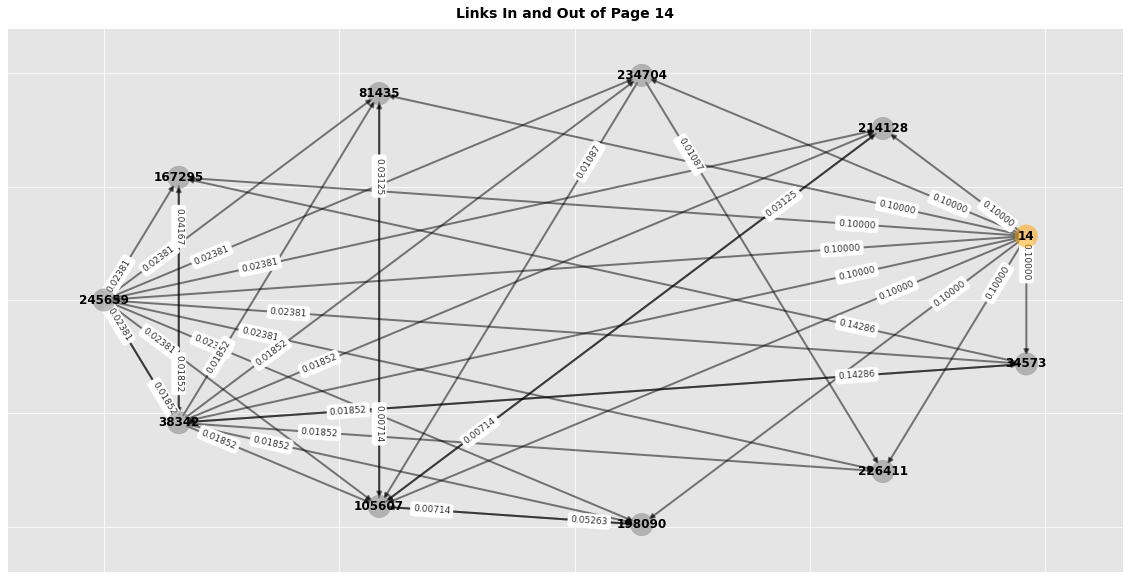

In [5]:
#define node
node_num = 14

#create subgraph
nodes1 = np.unique(stanweb_df[stanweb_df[0].isin([node_num])][0])
nodes2 = np.unique(stanweb_df[stanweb_df[0].isin([node_num])][1])
nodes1_2 = np.concatenate([nodes1, nodes2])

subgraph = graph.subgraph(nodes1_2)

# execute function
_ = plot_graph(subgraph, f'Links In and Out of Page {node_num}',[node_num], size = (20, 10))

## Power Method 

In mathematics, **power iteration** (also known as the **power method**) is an eigenvalue algorithm: given a diagonalizable matrix $A$, the algorithm will produce a number $\lambda$, which is the greatest (in absolute value) eigenvalue of $A$, and a nonzero vector $v$, which is a corresponding eigenvector of $\lambda$, that is, $Av=\lambda v$. The algorithm is also known as the Von Mises iteration. Power iteration is a very simple algorithm, but it may converge slowly. The most time-consuming operation of the algorithm is the multiplication of matrix $A$ by a vector, so it is effective for a very large sparse matrix with appropriate implementation.

For more information, please see the paper **[Deeper Inside PageRank](https://github.com/sapaladas/msc_data_science/blob/main/q3-numerical_optimization_and_large_scale_linear_algebra/pagerank/readings/pagerank.pdf)** from Amy N. Langville and Carl D. Meyer, published in October 20, 2004.

#### *Function for the Power method*

- $ x^{(k)T} = \alpha x^{(k-1)T} P + (\alpha x^{(k-1)T} a + (1-\alpha))v^T $

In [6]:
def power_method(P_matrix, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None):
    if max_iterations is None:
        max_iterations = np.iinfo(np.int32).max

    iterations = 1
    n = P_matrix.shape[0]
    ranks = None
    per_iteration_convergence = []
    metrics = []
    
    # This is the n-vector, containing 0 where there is no dangling node,1 otherwise
    a = np.asarray((np.sum(P_matrix, axis=1)[:, 0] == 0).astype(np.int32))
    
    # The n-vector of the power method equation 
    v = scipy.sparse.csr_matrix(np.ones(shape=(n, 1), dtype=np.float64) / n)
    
    # Initial vector for the power iteration.
    x_0 = scipy.sparse.csr_matrix(np.ones(shape=(n, 1), dtype=np.float64) / n)
    
    # Convergence exit condition.
    not_converged = True

    iteration_start_time = time.time()
    
    # Repeat until convergence.
    while not_converged and iterations < max_iterations:

        x = (alpha * x_0.T).dot(P_matrix) + ((alpha * x_0.T).dot(a) + (1 - alpha))[0, 0] * v.T

        # Convergence condition.
        error = np.linalg.norm((x.T - x_0).toarray(), ord=2) / np.linalg.norm(x.T.toarray(), ord=2)
                
         # In order to keep track of convergence we store, per iteration, the vector x, sorted in descending order.    
        if isinstance(per_iteration_convergence, list):
            per_iteration_convergence.append((np.argsort(-np.asarray(x.todense())) + 1).reshape(n))
        else:
            per_iteration_convergence = per_iteration_convergence.tolist()
            per_iteration_convergence.append((np.argsort(-np.asarray(x.todense())) + 1).reshape(n))

        x_0 = x.T.copy()

        # Exit condition
        if error <= tolerance:
            not_converged = False
        
        # Store iteration statistics
        metrics.append([iterations, error])

        if info:
            iteration_time = (time.time() - iteration_start_time) * 1000
            print('Iteration', iterations, '\t\t', 'Time (millis)', str(int(iteration_time)), '\t\t', 'Error', error)

        # update iterations    
        iterations += 1
        
    # Compute the vector of page ranks.
    # Adding one turns zero-based indexing to page indexing.    
    ranks = (np.argsort(-np.asarray(x.todense())) + 1).reshape(n)
    per_iteration_convergence = np.array(per_iteration_convergence)

    iteration_end_time = time.time()
    
    return iterations,(iteration_end_time - iteration_start_time),ranks, per_iteration_convergence, metrics

## Gauss-Seidel Method

In numerical linear algebra, the **Gauss–Seidel method**, also known as the **Liebmann method** or the **method of successive displacement**, is an iterative method used to solve a system of linear equations. It is named after the German mathematicians Carl Friedrich Gauss and Philipp Ludwig von Seidel, and is similar to the Jacobi method. Though it can be applied to any matrix with non-zero elements on the diagonals, convergence is only guaranteed if the matrix is either strictly diagonally dominant, or symmetric and positive definite. It was only mentioned in a private letter from Gauss to his student Gerling in 1823. A publication was not delivered before 1874 by Seidel.

For more information, please see the paper **[Deeper Inside PageRank](https://github.com/sapaladas/msc_data_science/blob/main/q3-numerical_optimization_and_large_scale_linear_algebra/pagerank/readings/pagerank.pdf)** from Amy N. Langville and Carl D. Meyer, published in October 20, 2004.

#### *Function for the Gauss-Seidel method*
- $ \pi^{T}=(v_{1}^{T}(I-\alpha P_{11})^{-1} | \alpha v_{1}^{T}(I-\alpha P_{11})^{-1} P_{12} + v_{2}^{T}) $

In [7]:
def gauss_seidel_method(P_matrix, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None):
    if max_iterations is None:
        max_iterations = np.iinfo(np.int32).max

    not_converged = True

    A = (scipy.sparse.eye(P_matrix.shape[0], format='csc') - alpha * P_matrix).T
    MG = scipy.sparse.tril(A, k=0, format='csc') 
    RG = -scipy.sparse.triu(A, k=1, format='csc')
        
    N = P_matrix.shape[0]
    v = scipy.sparse.csc_matrix(np.ones((N, 1)) / N)
    b = scipy.sparse.csc_matrix(((1 - alpha) * v))
    x_0 = scipy.sparse.csc_matrix(np.ones((N, 1)) / N)
    
    iterationsGS = 1
    per_iteration_convergenceGS = []
    metricsGS = []
    
    iteration_start_timeGS = time.time()

    while not_converged and iterationsGS < max_iterations:

        xGS = x_0.copy()      
        xGS = scipy.sparse.linalg.spsolve(MG, RG.dot(xGS.reshape(N, 1)) + b.reshape(N, 1))
                
        error = np.linalg.norm(xGS.reshape(N, 1) - x_0.reshape(N, 1), ord=1)
                
        if isinstance(per_iteration_convergenceGS, list):
            per_iteration_convergenceGS.append((np.argsort(-np.asarray(xGS)) + 1).reshape(N))
        else:
            per_iteration_convergenceGS = per_iteration_convergenceGS.tolist()
            per_iteration_convergenceGS.append((np.argsort(-np.asarray(xGS.todense())) + 1).reshape(N))
        
        if error <= tolerance:
            not_converged = False

        x_0 = xGS

        metricsGS.append([iterationsGS, error])

        if info:
            iteration_timeGS = (time.time() - iteration_start_timeGS) * 1000
            print('Iteration', iterationsGS, '\t\t', 'Time (millis)', str(int(iteration_timeGS)), '\t\t', 'Error', error)

        iterationsGS += 1

    xGS = xGS / np.linalg.norm(xGS, ord=1)
    ranksGS = np.argsort(-np.asarray(xGS), axis=0) + 1
    per_iteration_convergenceGS = np.array(per_iteration_convergenceGS)

    iteration_end_timeGS = time.time()
    
    return iterationsGS,(iteration_end_timeGS - iteration_start_timeGS),ranksGS, per_iteration_convergenceGS, metricsGS

# Example usage:
# ranksGS, per_iteration_convergenceGS, metricsGS = power_iteration(your_P_matrix, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None)

## Question 1 

Find the vector $\pi$ with ***i) the Power method*** and ***ii) the Gauss-Seidel method*** as they described in paragraph 5.1 and 5.2 of the tutorial. For both methods consider as $\alpha = 0.85$, stopping criterion $\tau = 10^{-8}$ and the vector $\alpha$ having $1$ if it corresponds to a node with no out links and $0$ otherwise. Are the results the same for both methods? Which method seems to be faster?</p>

In [8]:
# Power method:
iterations, elapsed_time, ranks, per_iteration_convergence, metrics = \
        power_method(P_matrix, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None)

# Gauss-Seidel method
iterationsGS, elapsed_timeGS, ranksGS, per_iteration_convergenceGS, metricsGS = \
        gauss_seidel_method(P_matrix, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None)

In [60]:
print(f'PageRank using the Power Method with alpha = 0.85')
print('='*60)
print(f'No Iterations: {iterations}')
print(f'Elapsed time (s): {elapsed_time} seconds \n\n')

print(f'PageRank using the Gauss-Seidel Method with alpha = 0.85')
print('='*60)
print(f'No Iterations: {iterationsGS}')
print(f'Elapsed time (s): {elapsed_timeGS} seconds')

PageRank using the Power Method with alpha = 0.85
No Iterations: 98
Elapsed time (s): 10.231465101242065 seconds 


PageRank using the Gauss-Seidel Method with alpha = 0.85
No Iterations: 47
Elapsed time (s): 24.248490571975708 seconds


#### *Function to plot the convergence for each method*

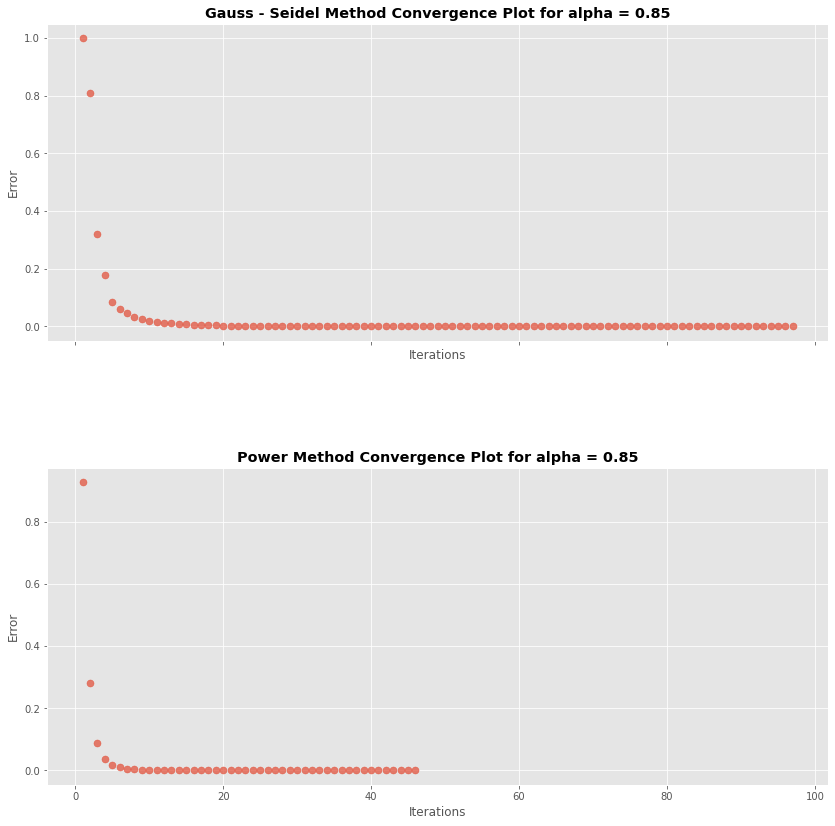

In [19]:
def plot_convergence(metrics, metricsGS, alpha):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), sharex=True, gridspec_kw={'hspace': 0.4})

    # Plotting the first axis
    ax1.scatter(x=np.asarray(metrics)[:, 0], y=np.asarray(metrics)[:, 1], marker='o', s=50, alpha=0.7)
    ax1.set_title(f'Gauss - Seidel Method Convergence Plot for alpha = {alpha}', fontweight='bold')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Error')

    # Plotting the second axis
    ax2.scatter(x=np.asarray(metricsGS)[:, 0], y=np.asarray(metricsGS)[:, 1], marker='o', s=50, alpha=0.7)
    ax2.set_title(f'Power Method Convergence Plot for alpha = {alpha}', fontweight='bold')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Error')

    #plt.suptitle(y=0.95, fontsize=16, fontweight='bold')
    plt.show()

    return

# Example usage:
_ = plot_convergence(metrics, metricsGS, 0.85)

#### *Equal page rankings check*

In [21]:
eq_ranks = np.count_nonzero(ranks == ranksGS)
eq_ranks_perc = np.round((np.count_nonzero(ranks == ranksGS) / 
                          np.unique(np.concatenate([stanweb_df[0], stanweb_df[1]])).shape[0]), 3)

print('Number of Equal Ranks for alpha = 0.85:', eq_ranks)
print('='*60)
print('Equal Ranks Percentage for alpha = 0.85:', eq_ranks_perc)

Number of Equal Ranks for alpha = 0.85: 158806
Equal Ranks Percentage for alpha = 0.85: 0.563


##### *Remarks*

- It seems that for an $\alpha$ value of **0.85**, both *Power* method and *Gauss-Seidel* method return the same results for *56.3 %* of the nodes
- Also, solving the PageRank problem with the *Power* method took ***92 iterations*** and ***10 seconds*** for the algorithm to converge
- On the other hand, even though the *Gauss-Seidel* method only took ***47 iterations***, it required ***24 seconds***

---

## Question 2

Do the previous task with $\alpha=0.99$. Your remarks on the convergence speed. Did the ranking of the first 50 nodes changed?

In [22]:
# Power method:
iterations_v2, elapsed_time_v2, ranks_v2, per_iteration_convergence_v2, metrics_v2 = \
        power_method(P_matrix, alpha=0.99, tolerance=1e-8, info=False, max_iterations=None)

# Gauss-Seidel method
iterationsGS_v2, elapsed_timeGS_v2, ranksGS_v2, per_iteration_convergenceGS_v2, metricsGS_v2 = \
        gauss_seidel_method(P_matrix, alpha=0.99, tolerance=1e-8, info=False, max_iterations=None)

In [61]:
print(f'PageRank using the Power Method with alpha = 0.99')
print('='*60)
print(f'No Iterations: {iterations_v2}')
print(f'Elapsed time (s): {elapsed_time_v2} seconds \n\n')

print(f'PageRank using the Gauss-Seidel Method with alpha = 0.99')
print('='*60)
print(f'No Iterations: {iterationsGS_v2}')
print(f'Elapsed time (s): {elapsed_timeGS_v2} seconds')

PageRank using the Power Method with alpha = 0.99
No Iterations: 1613
Elapsed time (s): 187.50646924972534 seconds 


PageRank using the Gauss-Seidel Method with alpha = 0.99
No Iterations: 581
Elapsed time (s): 325.9769833087921 seconds


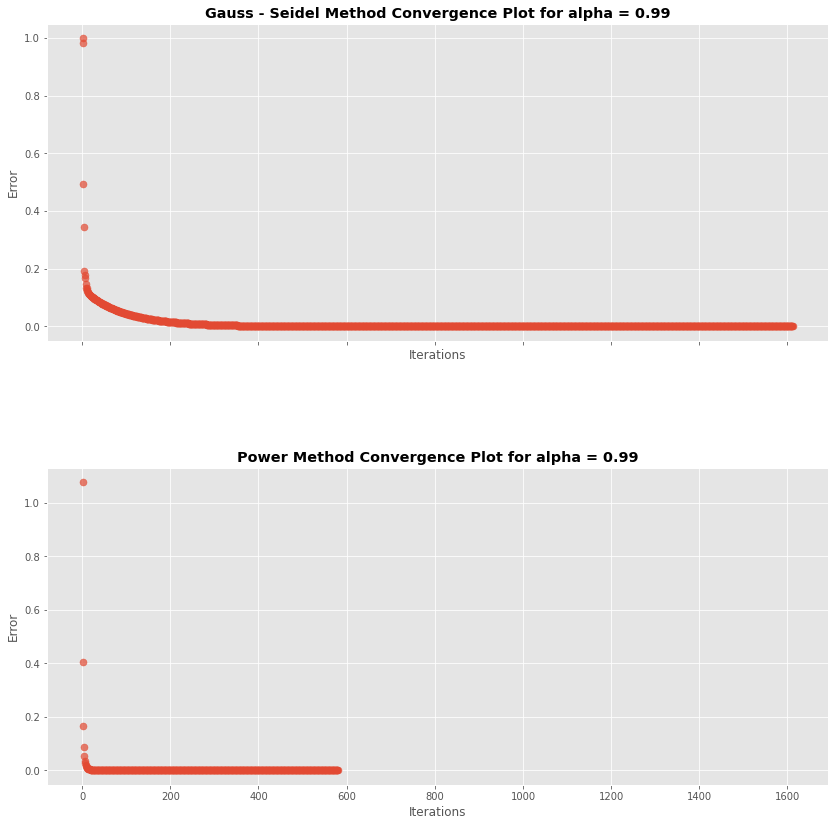

In [24]:
_ = plot_convergence(metrics_v2, metricsGS_v2, 0.99)

#### *Equal page rankings check*

In [26]:
eq_ranks_v2 = np.count_nonzero(ranks_v2 == ranksGS_v2)
eq_ranks_perc_v2 = np.round((np.count_nonzero(ranks_v2 == ranksGS_v2) / 
                          np.unique(np.concatenate([stanweb_df[0], stanweb_df[1]])).shape[0]), 3)

print('Number of Equal Ranks for alpha = 0.99:', eq_ranks_v2)
print('='*60)
print('Equal Ranks Percentage for alpha = 0.99:', eq_ranks_perc_v2)

Number of Equal Ranks for alpha = 0.99: 147541
Equal Ranks Percentage for alpha = 0.99: 0.523


#### *Top 50 nodes page ranking check*

In [28]:
ranks_df = pd.DataFrame({'Power (a = 0.85)': ranks[0:50].reshape(50), 
        'Power (a = 0.99)': ranksGS[0:50].reshape(50), 
        'Gauss-Seidel (a = 0.85)': ranks_v2[0:50].reshape(50),
        'Gauss-Seidel (a = 0.99)': ranksGS_v2[0:50].reshape(50)})

ranks_df

,Power (a = 0.85),Power (a = 0.99),Gauss-Seidel (a = 0.85),Gauss-Seidel (a = 0.99)
0,89073,89073,136821,136821
1,226411,226411,68889,68889
2,241454,241454,95163,272442
3,134832,134832,272442,251796
4,136821,136821,251796,95163
5,68889,68889,119479,119479
6,67756,67756,117152,117152
7,69358,69358,235496,235496
8,272442,272442,27904,27904
9,251796,251796,272762,272762


##### *Comments*

- Changing the value of $\alpha$ from **0.85** to **0.99**, resulted in some changes
- In particular, *Power* method and *Gauss-Seidel* method return the same results only for the first 10 nodes now
- Furthermore, we have some major changes in the convergence times
- The *Power* method needed, ***1613 iterations*** to converge and it took ***187 seconds***
- The *Gauss-Seidel* method needed ***581 iterations***, but it took ***325 seconds***.
- Finally, we found that changing the value of $\alpha$ the results for the first 50 nodes changed even when using the same method
- Regarding the equal page rankings we note a slight drop in the percentage (52.3% to 56.3%)
---

## Question 3 

When we use the power method, do all the components of $\pi$ converge at the same speed to their limits? If not, which of them converge faster: those that correspond to important nodes or to non important? Do you observe the same behavior when you find $\pi$ through the solution of the linear system?

- Assessing the convergence speed of nodes using graphical representation is a key aspect of our analysis.
- The graph generated will depict the progression of convergence across iterations.
- The expectation is that nodes converging early will exhibit initial fluctuations in the first few iterations before stabilizing into a consistent pattern.
- Our visualization will focus on plotting the convergence patterns of the first and last 12 nodes for each method.

##### *Function to plot components convergence*

In [29]:
def plot_comp_convergence(per_iteration_convergence, from_ranking = 0, to_ranking = 12, size = (10, 10), title = None):
    
    per_iteration_convergence_df = pd.DataFrame(per_iteration_convergence)

    _, ax = plt.subplots(figsize = size)

    if title != None:
        ax.set_title(label = title, loc = 'center', fontweight="bold", fontsize = 20)

    ax.yaxis.set_major_locator(plt.NullLocator())
    per_iteration_convergence_df.iloc[:, from_ranking:to_ranking] \
        .plot(title = title, colormap = 'tab20b', sharex = True, layout = (10, 2), subplots = True, ax = ax)

    return ax

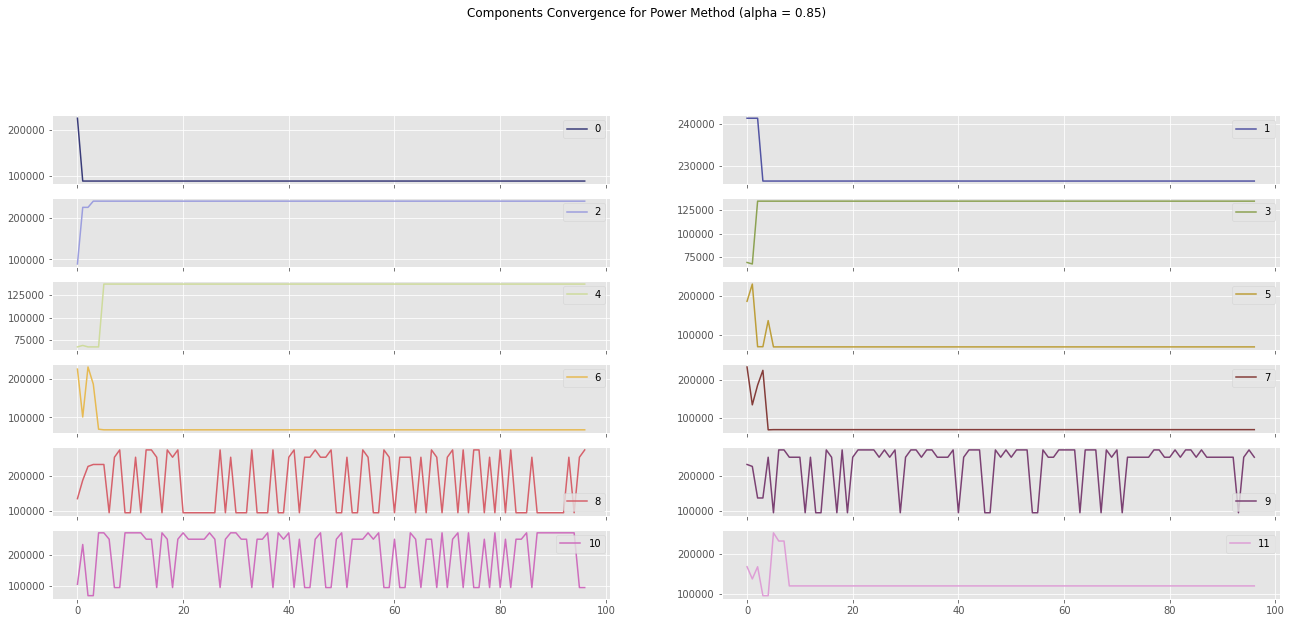

In [30]:
_ = plot_comp_convergence(per_iteration_convergence,0,12,(22,15),'Components Convergence for Power Method (alpha = 0.85)')

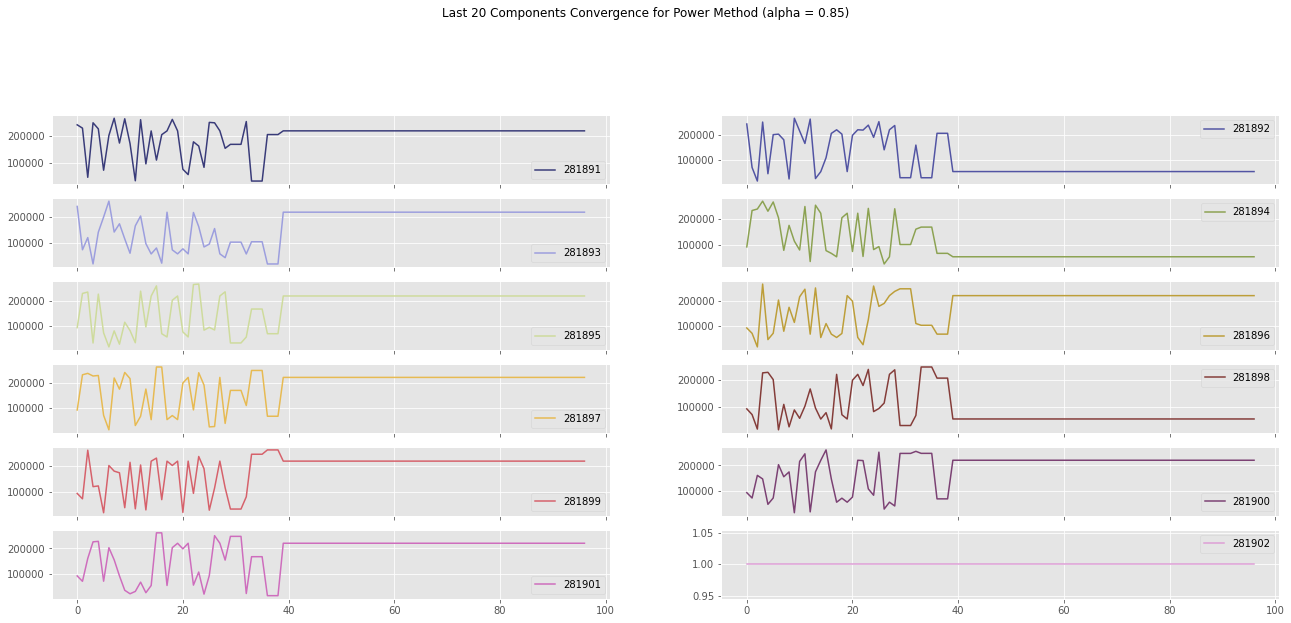

In [31]:
_= plot_comp_convergence(per_iteration_convergence, per_iteration_convergence.shape[1] - 12,
                      per_iteration_convergence.shape[1],(22,15),'Last 20 Components Convergence for Power Method (alpha = 0.85)')

<Axes: >

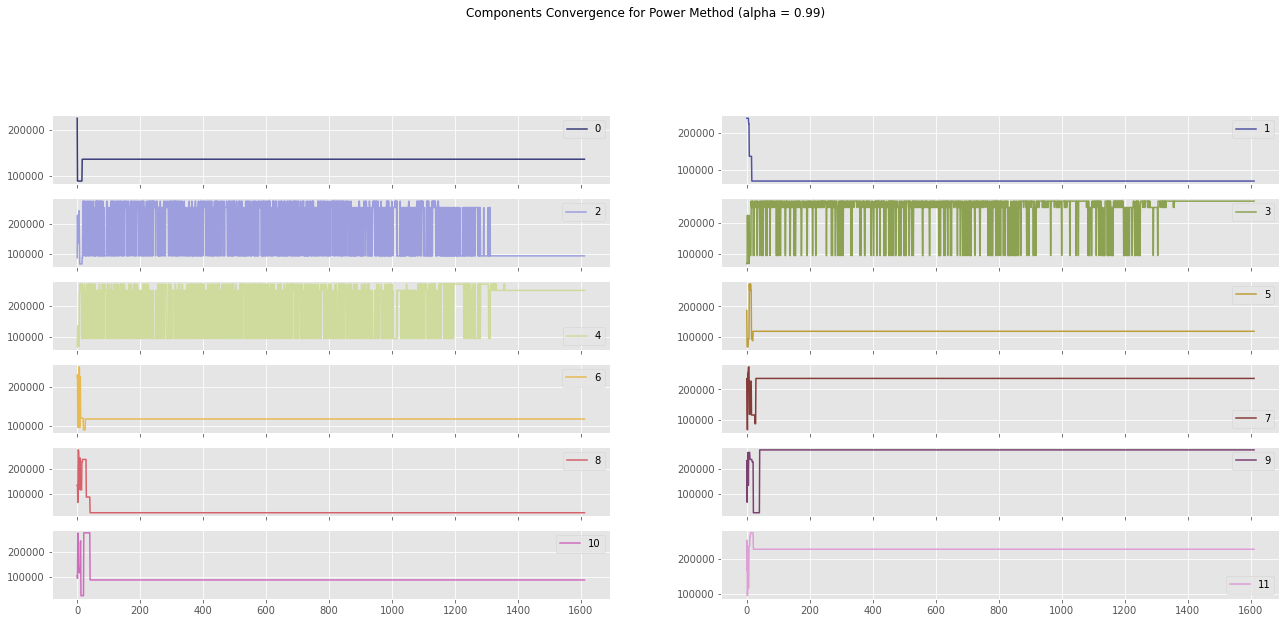

In [32]:
plot_comp_convergence(per_iteration_convergence_v2,0,12,(22, 15),'Components Convergence for Power Method (alpha = 0.99)')

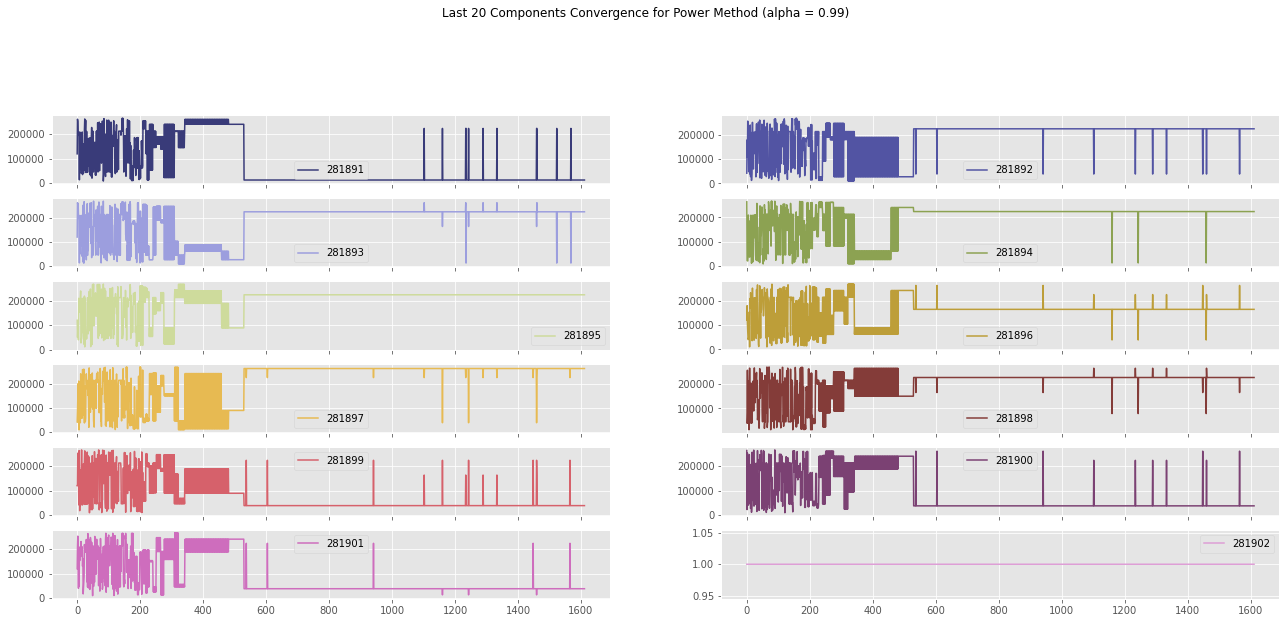

In [33]:
_ = plot_comp_convergence(per_iteration_convergence_v2, per_iteration_convergence_v2.shape[1] - 12,
                      per_iteration_convergence_v2.shape[1],(22,15),'Last 20 Components Convergence for Power Method (alpha = 0.99)')

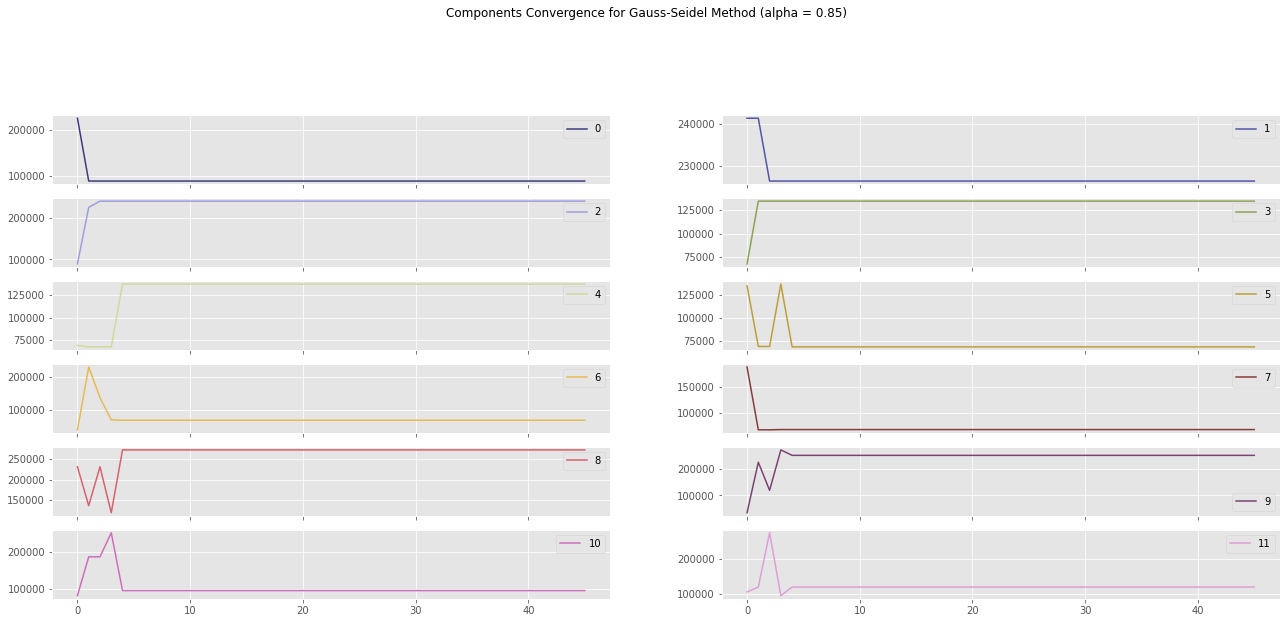

In [34]:
_= plot_comp_convergence(per_iteration_convergenceGS,0,12,(22,15),'Components Convergence for Gauss-Seidel Method (alpha = 0.85)')

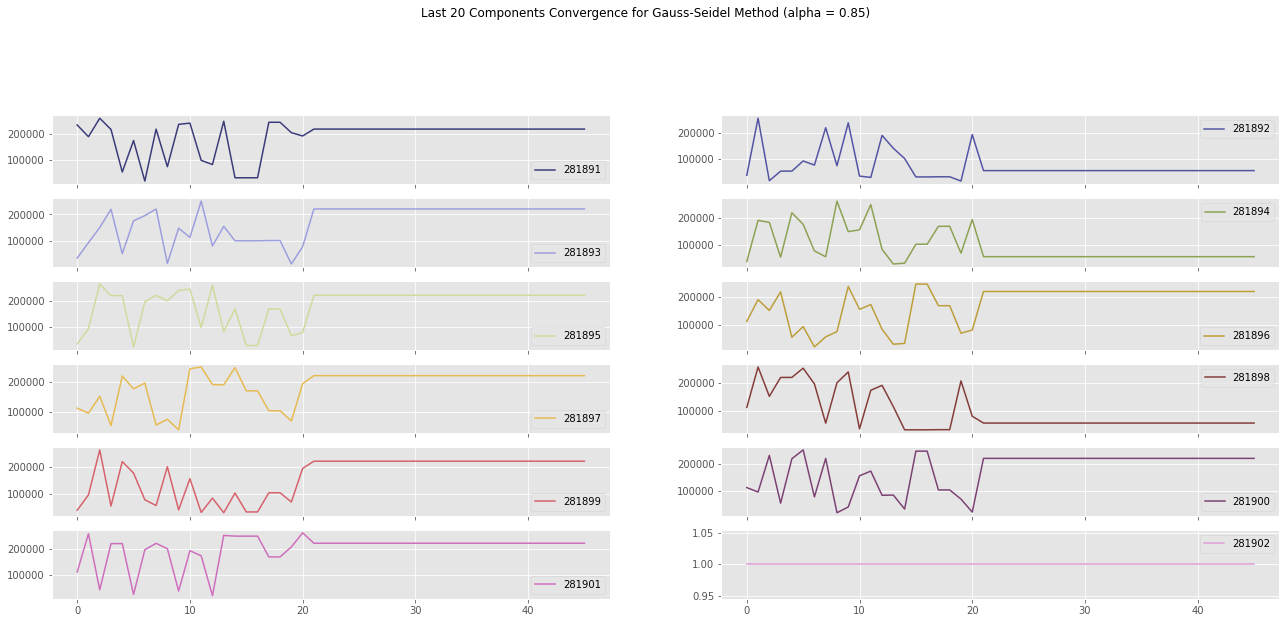

In [35]:
_ = plot_comp_convergence(per_iteration_convergenceGS, per_iteration_convergenceGS.shape[1] - 12,
                      per_iteration_convergenceGS.shape[1],(22,15),
                       'Last 20 Components Convergence for Gauss-Seidel Method (alpha = 0.85)')

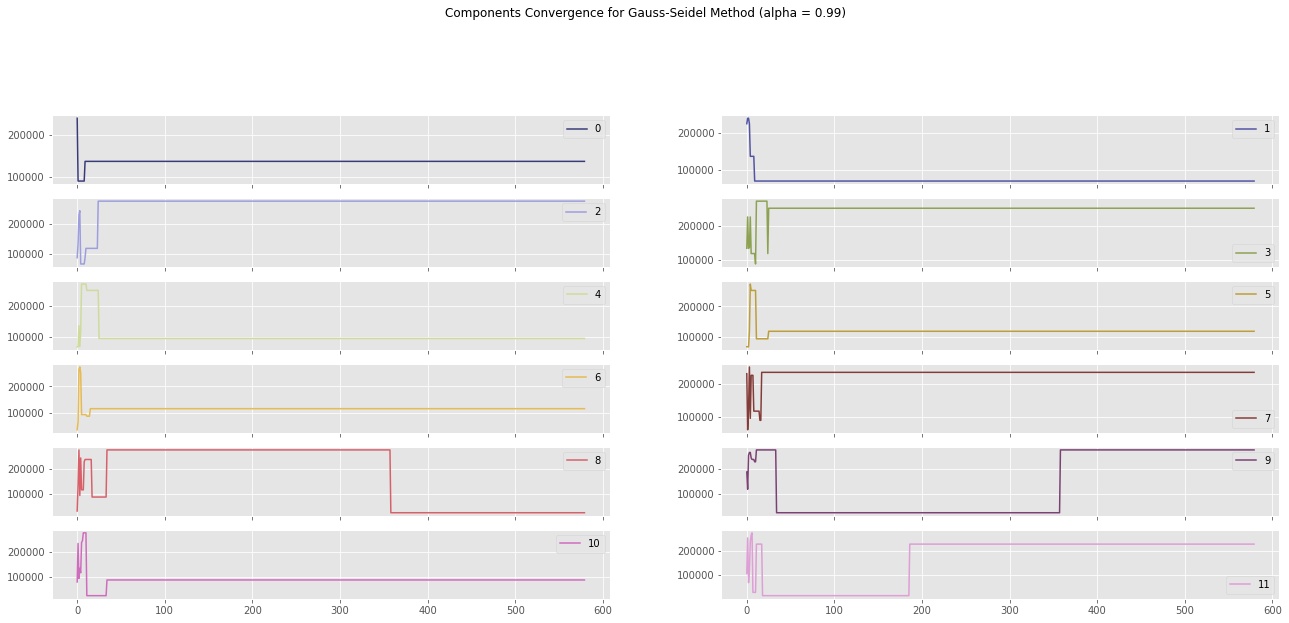

In [37]:
_= plot_comp_convergence(per_iteration_convergenceGS_v2,0,12,(22, 15),'Components Convergence for Gauss-Seidel Method (alpha = 0.99)')

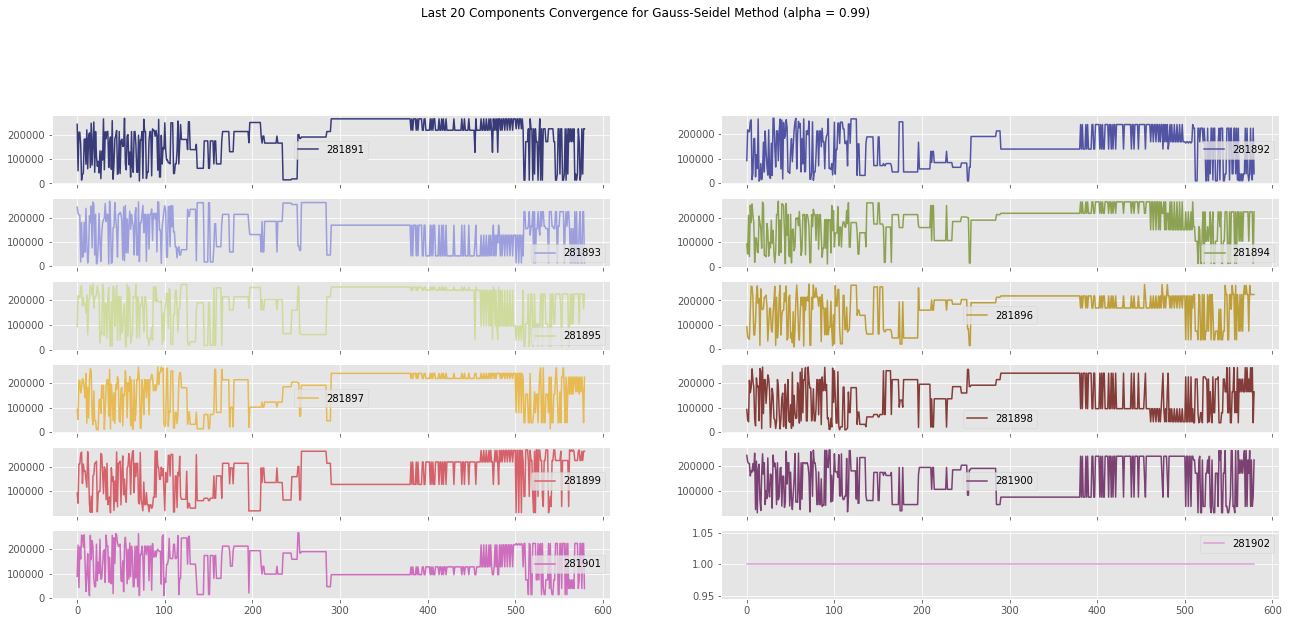

In [38]:
_ = plot_comp_convergence(per_iteration_convergenceGS_v2, per_iteration_convergenceGS_v2.shape[1] - 12,
                      per_iteration_convergenceGS_v2.shape[1],(22,15),
                       'Last 20 Components Convergence for Gauss-Seidel Method (alpha = 0.99)')

##### *Remarks*

In general, nodes with higher ranks typically require more iterations, on average, to achieve convergence compared to their lower-ranked counterparts. This phenomenon arises from the network structure: lower-ranked nodes usually have more outbound links than inbound links, facilitating a quicker convergence of their pagerank. Conversely, higher-ranked nodes tend to possess numerous inbound links, causing their pagerank to increase until convergence. This aligns with the fundamental principles of PageRank, which gauges a page's importance based on the quantity and quality of links it receives. The logic is rooted in the assumption that more crucial websites are prone to attract more links from other web sources.

# Part 2

## Question 1

You now create a new web page X (thus adding a node to the web graph). X has neither in-links, nor out-links. 

##### *Add new page X to the graph*

In [39]:
X = 281904

graph.add_node(X)
P_matrix_new = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

P_matrix_new[X - 1, X - 1] = 1.0

In [40]:
# Power method:
iterations_x, elapsed_time_x, ranks_x, per_iteration_convergence_x, metrics_x = \
        power_method(P_matrix_new, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None)

In [44]:
print(f'PageRank using the Power Method with alpha = 0.85')
print('='*60)
print(f'No Iterations: {iterations_x}')
print(f'Elapsed time (s): {elapsed_time_x} seconds \n')

print('='*60)
print('The Rank of Page X is:', np.where(ranks_x == X)[0][0])

PageRank using the Power Method with alpha = 0.85
No Iterations: 98
Elapsed time (s): 11.565057516098022 seconds 

The Rank of Page X is: 42593


## Question 2

You create another page Y (with no in-links) that links to X. Does the PageRank of X improve?

##### *Add new page Y to the graph*

In [45]:
Y = 281905

graph.add_node(Y)
graph.add_edge(Y, X, weight = 1.0)

P_matrix_new = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

In [46]:
# Power method:
iterations_xy, elapsed_time_xy, ranks_xy, per_iteration_convergence_xy, metrics_xy = \
        power_method(P_matrix_new, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None)

In [47]:
print(f'PageRank using the Power Method with alpha = 0.85')
print('='*60)
print(f'No Iterations: {iterations_xy}')
print(f'Elapsed time (s): {elapsed_time_xy} seconds \n')

print('='*60)
print('The Rank of Page X is:', np.where(ranks_xy == X)[0][0])
print('The Rank of Page Y is:', np.where(ranks_xy == Y)[0][0])

PageRank using the Power Method with alpha = 0.85
No Iterations: 98
Elapsed time (s): 10.951723098754883 seconds 

The Rank of Page X is: 141864
The Rank of Page Y is: 281904


- As we can see the rank of Page X has decreased

## Question 3

Still unsatisfied, you create a third page Z

##### *Add new page Z to the graph*

In [48]:
Z = 281906

graph.add_node(Z)
graph.add_edge(Z, Y, weight = 1.0)

P_matrix_new = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

In [49]:
# Power method:
iterations_xyz, elapsed_time_xyz, ranks_xyz, per_iteration_convergence_xyz, metrics_xyz = \
        power_method(P_matrix_new, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None)

In [50]:
print(f'PageRank using the Power Method with alpha = 0.85')
print('='*60)
print(f'No Iterations: {iterations_xyz}')
print(f'Elapsed time (s): {elapsed_time_xyz} seconds \n')

print('='*60)
print('The Rank of Page X is:', np.where(ranks_xyz == X)[0][0])
print('The Rank of Page Y is:', np.where(ranks_xyz == Y)[0][0])
print('The Rank of Page Y is:', np.where(ranks_xyz == Z)[0][0])

PageRank using the Power Method with alpha = 0.85
No Iterations: 98
Elapsed time (s): 11.573045492172241 seconds 

The Rank of Page X is: 107045
The Rank of Page Y is: 141899
The Rank of Page Y is: 281905


- Now both the ranks of pages X and Y have increased

## Question 4

You have one last idea, you add links from your page X to older, popular pages. Does this improve the PageRank of X? Does the answer change if you add links from Y or Z to older, popular pages?

- Here we will link page X to the 10 most popular pages in terms of ranking that we calculated with the Power Method (a = 0.85)
- Then we will plot the corresponding subgraph and recalculate the rank of page X
- ***The Rank of page X does not increase***

##### *Link page X with the 10 most popular  pages*

In [51]:
k = 10

top_k_ranks = ranks[0:k]
top_k_ranks_with_weights = np.zeros((k, 2))

for i in range(0, k):
    top_k_ranks_with_weights[i, 0] = top_k_ranks[i]
    top_k_ranks_with_weights[i, 1] = 1 / k

X = 281904
inlinks = None
outlinks = top_k_ranks_with_weights

graph.add_node(X)

for i in range(0, outlinks.shape[0]):
    graph.add_edge(X, outlinks[i, 0].astype(np.int32), weight = outlinks[i, 1].astype(np.float64))

P_matrix_new_d = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

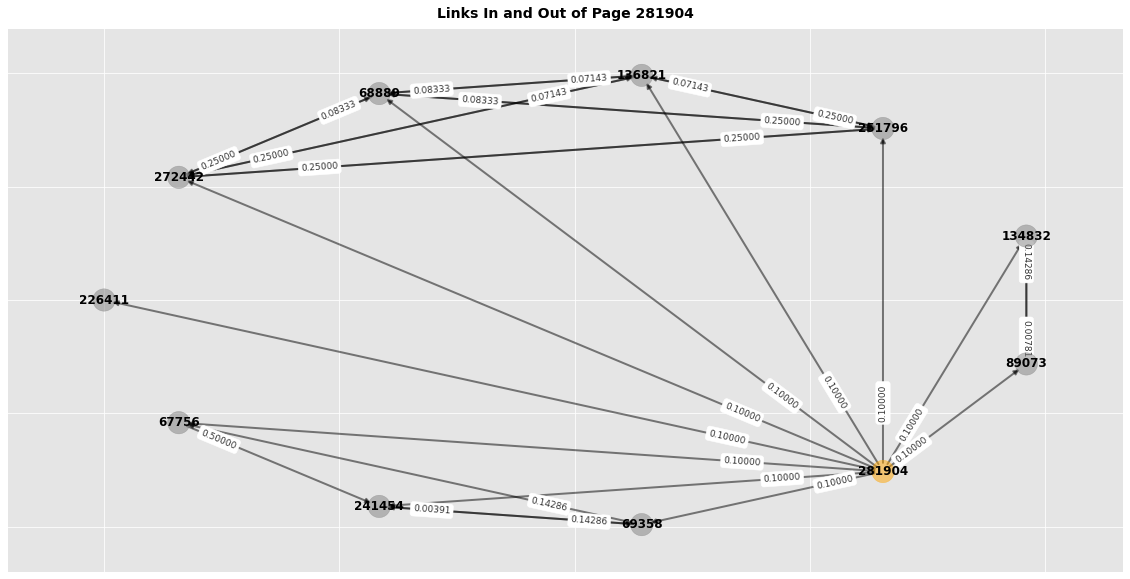

In [52]:
subgraph = graph.subgraph(np.concatenate([[X], top_k_ranks]))
_ = plot_graph(subgraph, f'Links In and Out of Page {X}',highlight_nodes = [X], size = (20, 10))

In [53]:
# Power method:
iterations_k, elapsed_time_k, ranks_k, per_iteration_convergence_k, metrics_k = \
        power_method(P_matrix_new_d, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None)

In [54]:
print(f'PageRank using the Power Method with alpha = 0.85')
print('='*60)
print(f'No Iterations: {iterations_k}')
print(f'Elapsed time (s): {elapsed_time_k} seconds \n')

print('='*60)
print('The Rank of Page X is:', np.where(ranks_k == X)[0][0])

PageRank using the Power Method with alpha = 0.85
No Iterations: 98
Elapsed time (s): 11.452730178833008 seconds 

The Rank of Page X is: 107045


##### *We add links to pages Y and Z*

In [55]:
Y = 281905
Z = 281906
inlinks = None
outlinks = top_k_ranks_with_weights

graph.add_node(Y)

for i in range(0, outlinks.shape[0]):
    graph.add_edge(Y, outlinks[i, 0].astype(np.int32), weight = outlinks[i, 1].astype(np.float64))
    
for i in range(0, outlinks.shape[0]):
    graph.add_edge(Z, outlinks[i, 0].astype(np.int32), weight = outlinks[i, 1].astype(np.float64))

    
P_matrix_new_dd = nx.to_scipy_sparse_matrix(graph, np.sort(graph.nodes), format = 'csr', dtype = np.float64)

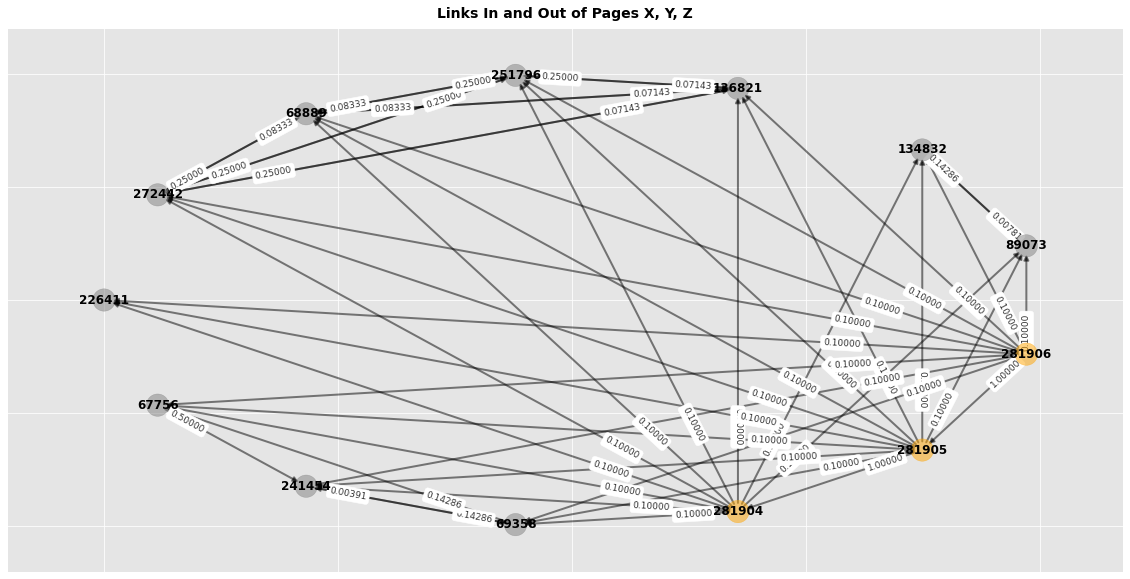

In [57]:
subgraph = graph.subgraph(np.concatenate([[X,Y,Z], top_k_ranks]))
_ = plot_graph(subgraph, f'Links In and Out of Pages X, Y, Z',highlight_nodes = [X,Y,Z], size = (20, 10))

In [58]:
# Power method:
iterations_kk, elapsed_time_kk, ranks_kk, per_iteration_convergence_kk, metrics_kk = \
        power_method(P_matrix_new_dd, alpha=0.85, tolerance=1e-8, info=False, max_iterations=None)

In [59]:
print(f'PageRank using the Power Method with alpha = 0.85')
print('='*60)
print(f'No Iterations: {iterations_kk}')
print(f'Elapsed time (s): {elapsed_time_kk} seconds \n')

print('='*60)
print('The Rank of Page X is:', np.where(ranks_kk == X)[0][0])

PageRank using the Power Method with alpha = 0.85
No Iterations: 98
Elapsed time (s): 11.47933053970337 seconds 

The Rank of Page X is: 107045


- **As we can see the rank of page X remains the same**